### main_pretrain

In [1]:
from main_pretrains.main_pretrain import main_pretrain, set_seed
from models.lstm import LSTM_SOH
from data_provider import data_provider
import torch
import torch.optim as optim
import random
import numpy as np

source_set_train, source_loader_train = data_provider(name = 'GOTION', shuffle_flag=True, batch_size=10, flag = 'train')
source_set_test, source_loader_test = data_provider(name = 'GOTION', shuffle_flag=False, batch_size=10, flag = 'test')

# model parameters
input_dim = 1
embed_dim = 128
# num_heads = 4
num_layers = 2

# training parameters
mask_ratrio = 0.3
num_epochs = 15
LR = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
f_g = LSTM_SOH(input_dim, embed_dim,  num_layers, PPA= True).to(device)
optimizer = optim.AdamW(f_g.parameters(), lr=LR)
set_seed(0)
main_pretrain(train_loader= source_loader_train, test_loader= source_loader_test, model=f_g, optimizer=optimizer, device=device,mask_ratio=mask_ratrio, num_epochs=num_epochs)
torch.save(f_g.state_dict(), 'saved_models/lstm/f_g.pt')

GOTION train 2840
GOTION test 1419
cuda
Epoch [1/15], Reconstruction (train) Loss: 0.004792311362955805, Reconstruction (test) Loss: 0.0006696570076009023
Epoch [2/15], Reconstruction (train) Loss: 0.00028944749467715977, Reconstruction (test) Loss: 0.00020308009195912132
Epoch [3/15], Reconstruction (train) Loss: 0.00017927555576611218, Reconstruction (test) Loss: 0.00015659500909542901
Epoch [4/15], Reconstruction (train) Loss: 0.0001097915087548629, Reconstruction (test) Loss: 0.0001037464575039823
Epoch [5/15], Reconstruction (train) Loss: 8.753486811105509e-05, Reconstruction (test) Loss: 8.91909486442824e-05
Epoch [6/15], Reconstruction (train) Loss: 5.9422461483438995e-05, Reconstruction (test) Loss: 7.996640075797471e-05
Epoch [7/15], Reconstruction (train) Loss: 4.856168277296041e-05, Reconstruction (test) Loss: 6.17846284845834e-05
Epoch [8/15], Reconstruction (train) Loss: 4.332124077772163e-05, Reconstruction (test) Loss: 8.474878122284844e-05
Epoch [9/15], Reconstruction (

### main_prob

In [80]:
from main_pretrains.main_prob import main_prob
from data_provider import data_provider
from models.lstm import LSTM_SOH
import torch
import torch.optim as optim
import torch.nn as nn
from main_pretrains.main_pretrain import set_seed

source_set_train, source_loader_train = data_provider(name = 'GOTION', shuffle_flag=True, batch_size=10, flag = 'train')
target_set_train, target_loader_train = data_provider(name = 'CALCE', shuffle_flag=False, batch_size=10, flag = 'train')
target_set_test, target_loader_test = data_provider(name = 'CALCE', shuffle_flag=False, batch_size=10, flag = 'test')

LR = 1e-3
EPOCH = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

f_g = LSTM_SOH(input_dim=1, embed_dim=128, num_layers=2, PPA= True).to(device)
f_g.load_state_dict(torch.load("saved_models/lstm/f_g.pt"))
regressor = nn.Linear(f_g.input_linear.out_features, 1).to(device)
optimizer = optim.AdamW(regressor.parameters(), lr=LR)

set_seed(4)
main_prob(source_loader_train, target_loader_train, combined_training=True, model=f_g, regressor=regressor, optimizer=optimizer, device=device, num_epochs=EPOCH)
torch.save(regressor.state_dict(), 'saved_models/lstm/regressor.pt')

GOTION train 2840
CALCE train 1173
CALCE test 637
cuda
Epoch [1/5], Source Loader Loss: 0.032758491156207936
Target Loader - MAE: 0.04171810671687126, RMSE: 0.04450475797057152
Epoch [2/5], Source Loader Loss: 0.0007909734823173699
Target Loader - MAE: 0.0345812551677227, RMSE: 0.037244152277708054
Epoch [3/5], Source Loader Loss: 0.0003823189070086736
Target Loader - MAE: 0.028430921956896782, RMSE: 0.03084147535264492
Epoch [4/5], Source Loader Loss: 0.00018336837161820165
Target Loader - MAE: 0.023985709995031357, RMSE: 0.026236018165946007
Epoch [5/5], Source Loader Loss: 0.00011475512056536055
Target Loader - MAE: 0.021589508280158043, RMSE: 0.02381102368235588


(637,)
(637,)


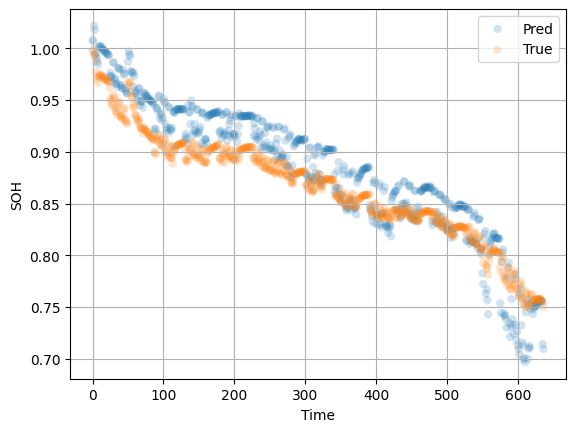

In [81]:
from drawings import drawDegradation
drawDegradation(target_loader_test=target_loader_test, model=f_g, regressor=regressor, device = device)

### tta

In [84]:
f_g = LSTM_SOH(input_dim=1, embed_dim=128,  num_layers=2,  PPA= True).to(device)
f_g.load_state_dict(torch.load("saved_models/lstm/f_g.pt"))
regressor = nn.Linear(f_g.input_linear.out_features, 1).to(device)
regressor.load_state_dict(torch.load("saved_models/lstm/regressor.pt"))

for name, param in f_g.named_parameters():
    if name =='soft_prompt':
        param.requires_grad = True
    else:
        param.requires_grad = False

# Print trainable and frozen parameters
print("Trainable parameters:")
trainable_params_count = 0
for name, param in f_g.named_parameters():
    if name =='soft_prompt':
        print('PPA params:', param.numel())
    if param.requires_grad:
        print(name)
        trainable_params_count += param.numel()

print("\nFrozen parameters:")
frozen_params_count = 0
for name, param in f_g.named_parameters():
    if not param.requires_grad:
        print(name)
        frozen_params_count += param.numel()

print(f"\nNumber of trainable parameters: {trainable_params_count}")
print(f"Total number of parameters: {trainable_params_count + frozen_params_count}")
print(f"Number of frozen parameters: {frozen_params_count}")

Trainable parameters:
PPA params: 1280
soft_prompt

Frozen parameters:
input_linear.weight
input_linear.bias
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l1
lstm.weight_hh_l1
lstm.bias_ih_l1
lstm.bias_hh_l1
output_linear.weight
output_linear.bias

Number of trainable parameters: 1280
Total number of parameters: 265857
Number of frozen parameters: 264577


In [83]:
from main_pretrains.main_tta import main_tta
from evaluator import evaluate

# optimizer = optim.SGD(f_g.parameters(), lr=1e-1)
optimizer = optim.SGD([f_g.soft_prompt], lr=50e-1)

set_seed(200)
mae, rmse = evaluate(model = f_g, model_name='lstm', regressor=regressor, target_loader=target_loader_test, device=device)
print(f"(Before TTA) MAE: {mae}, RMSE: {rmse}")
f_g=f_g.train()
main_tta(target_loader=target_loader_test, model=f_g, regressor=regressor, optimizer=optimizer, device=device, mask_ratio=0.8, num_epochs=10)

mae, rmse = evaluate(model = f_g, model_name='lstm', regressor=regressor, target_loader=target_loader_test, device=device)
print(f"(After TTA) MAE: {mae}, RMSE: {rmse}")

(Before TTA) MAE: 0.021689465269446373, RMSE: 0.02472773939371109
Epoch [1/10], TTA Reconstruction Loss: 0.006229321428691037
Target Loader - MAE: 0.018539905548095703, RMSE: 0.021597517654299736
Epoch [2/10], TTA Reconstruction Loss: 0.0036505327761915396
Target Loader - MAE: 0.01752515137195587, RMSE: 0.020626414567232132
Epoch [3/10], TTA Reconstruction Loss: 0.0027108981948913424
Target Loader - MAE: 0.016808079555630684, RMSE: 0.019958732649683952
Epoch [4/10], TTA Reconstruction Loss: 0.0019243441993239685
Target Loader - MAE: 0.016394117847085, RMSE: 0.01958725042641163
Epoch [5/10], TTA Reconstruction Loss: 0.0015541979437330156
Target Loader - MAE: 0.01607104390859604, RMSE: 0.01930605061352253
Epoch [6/10], TTA Reconstruction Loss: 0.0014345198537739634
Target Loader - MAE: 0.015874778851866722, RMSE: 0.01913817599415779
Epoch [7/10], TTA Reconstruction Loss: 0.0015028872414859507
Target Loader - MAE: 0.01566697284579277, RMSE: 0.01896425522863865
Epoch [8/10], TTA Reconstruc

In [29]:
mae, rmse = evaluate(model = f_g, model_name='lstm', regressor=regressor, target_loader=target_loader_test, device=device)
print(f"(Before TTA) MAE: {mae}, RMSE: {rmse}")
f_g=f_g.train()
main_tta(target_loader=target_loader_test, model=f_g, regressor=regressor, optimizer=optimizer, device=device, mask_ratio=0.95, num_epochs=200)

mae, rmse = evaluate(model = f_g, model_name='lstm', regressor=regressor, target_loader=target_loader_test, device=device)
print(f"(After TTA) MAE: {mae}, RMSE: {rmse}")

(Before TTA) MAE: 0.05057189613580704, RMSE: 0.05284135788679123
Epoch [1/200], TTA Reconstruction Loss: 0.02194784439598152
Target Loader - MAE: 0.04922590032219887, RMSE: 0.05143565684556961
Epoch [2/200], TTA Reconstruction Loss: 0.015158717505073582
Target Loader - MAE: 0.04944409430027008, RMSE: 0.051663532853126526
Epoch [3/200], TTA Reconstruction Loss: 0.008603666489761963
Target Loader - MAE: 0.04958110302686691, RMSE: 0.051806479692459106
Epoch [4/200], TTA Reconstruction Loss: 0.01314063349400385
Target Loader - MAE: 0.04928157851099968, RMSE: 0.05149400979280472
Epoch [5/200], TTA Reconstruction Loss: 0.011990271227205085
Target Loader - MAE: 0.049084726721048355, RMSE: 0.05128815397620201
Epoch [6/200], TTA Reconstruction Loss: 0.010995304082825896
Target Loader - MAE: 0.049194611608982086, RMSE: 0.0514032356441021
Epoch [7/200], TTA Reconstruction Loss: 0.009147953657702601
Target Loader - MAE: 0.04922735318541527, RMSE: 0.05143747106194496
Epoch [8/200], TTA Reconstructi

(637,)
(637,)


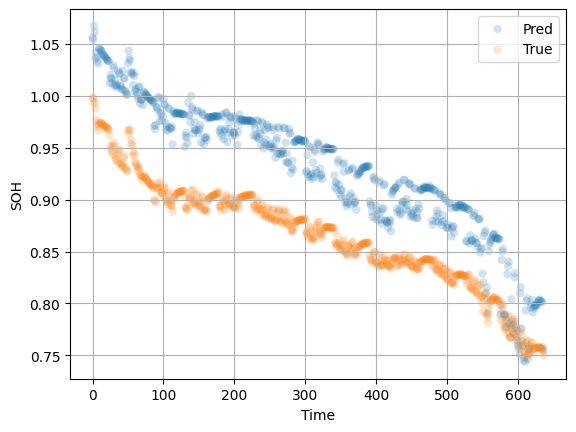

In [30]:
from drawings import drawDegradation
drawDegradation(target_loader_test=target_loader_test, model=f_g, regressor=regressor, device = device)

## TTA with PPA